## Domain adaptation

In [1]:
import fasttext
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy.stats
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DATADIR = "../data/"
DISTANCE = "distance"
FILEFASTTEXT = "fasttext.csv"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
ANDERS = "ANDERS"
EENS = "EENS"
ONEENS = "ONEENS"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
LABEL = "label"
TEXT = "text"
USER = "user"
LABELPREFIX = "__label__"
LARGEINT = 9999999999

In [3]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))
VALIDATION = "VALIDATION"+str(int(random.random()*LARGEINT))

In [4]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)


def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))


def preprocess(text):
    return(tokenize(cleanup(text)).lower())


def select_annotations(tweets, annotations, target_annotator):
    fasttext_data = {}
    for i in range(0,len(annotations)):
        annotator = annotations.iloc[i][0]
        tweet_id = annotations.iloc[i][2]
        if annotator == target_annotator and tweet_id in list(tweets.index):
            tweet_user = tweets.loc[tweet_id][1]
            tweet_label = annotations.iloc[i][4]
            if tweet_label == NEUTRAL: tweet_label = IRRELEVANT
            if tweet_label == ANDERS: tweet_label = IRRELEVANT
            if tweet_label == EENS: tweet_label = SUPPORTS
            if tweet_label == ONEENS: tweet_label = REJECTS
            fasttext_data[tweet_id] = { LABEL:LABELPREFIX+tweet_label,
                                        USER:tweet_user,
                                        TEXT:preprocess(tweets.loc[tweet_id][TEXT]) }
    return(fasttext_data)


def store_fasttext_data(fasttext_data):
    outfile = open(FILEFASTTEXT, "w")
    seen_texts = {}
    fasttext_data_list = []
    tweet_ids = []
    for tweet_id in fasttext_data:
        text = cleanup(fasttext_data[tweet_id][TEXT])
        if not text in seen_texts:
            print(fasttext_data[tweet_id][LABEL], text, file=outfile)
            fasttext_data_list.append(" ".join([fasttext_data[tweet_id][LABEL], text]))
            tweet_ids.append(tweet_id)
            seen_texts[text] = True
    outfile.close()
    return(fasttext_data_list, tweet_ids)

In [5]:
def make_fasttext_data(topic):
    if topic == DISTANCE:
        tweet_file = DATADIR + topic + "-tweets.csv"
    else:
        tweet_file = DATADIR + topic + "-tweets+nunl.csv"
    tweets = pd.read_csv(tweet_file, index_col=IDSTR)   
    annotations = pd.read_csv(tweet_file + ".human-labels.txt", header=None, sep=" ")        
    main_annotator = annotations.iloc[0][0]
    fasttext_data = select_annotations(tweets, annotations, main_annotator)
    fasttext_data_list, tweet_ids = store_fasttext_data(fasttext_data)
    return(fasttext_data_list, tweet_ids)

In [6]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True,printMatrix=False):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    if printMatrix:
        print(cf)
    for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
    numberOfPredictedSupportLabels = sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))])
    numberOfGoldSupportLabels = sum(cf.loc['__label__SUPPORTS'])
    numberOfPredictedRejectLabels = sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])
    numberOfGoldRejectLabels = sum(cf.loc['__label__REJECTS'])
    if numberOfPredictedSupportLabels > 0 and numberOfGoldRejectLabels > 0 and numberOfGoldSupportLabels > 0:
        fraction = (numberOfPredictedRejectLabels/numberOfPredictedSupportLabels)/(numberOfGoldRejectLabels/numberOfGoldSupportLabels)
    else:
        fraction = LARGEINT
    if printResults: 
        print("cases: {0}; precision: {1:0.3f}; recall: {2:0.3f}; fraction: {3:0.3f}".format(caseTotal,precision,recall,fraction))
    return((precision,fraction))

def runFasttext(fasttextData1,fasttextData2,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None,pretrainedVectors=None):
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData, k=3))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData, k=3))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [7]:
fasttext_data_list_distance, tweet_ids_distance = make_fasttext_data("distance")
fasttext_data_list_facemask, tweet_ids_facemask = make_fasttext_data("mondkapje")

## Evaluation within domains

In [8]:
def store_fasttext_data(data, file_name):
    with open(file_name, "wb") as outfile:
        pickle.dump(data, outfile)
        outfile.close()
        
def read_fasttext_data(file_name):
    with open(file_name, "rb") as infile:
        data = pickle.load(infile)
        infile.close()
    return(data)

In [39]:
predictionCountsValidationDD,predictionLabelsValidationDD,predictionCountsTestDD,predictionLabelsTestDD = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 573; precision: 0.691; recall: 0.691; fraction: 0.996
1 cases: 573; precision: 0.754; recall: 0.754; fraction: 1.188
2 cases: 573; precision: 0.555; recall: 0.555; fraction: 0.784
3 cases: 573; precision: 0.628; recall: 0.628; fraction: 1.165
4 cases: 574; precision: 0.622; recall: 0.622; fraction: 1.152
5 cases: 573; precision: 0.640; recall: 0.640; fraction: 0.741
6 cases: 573; precision: 0.660; recall: 0.660; fraction: 0.714
7 cases: 573; precision: 0.695; recall: 0.695; fraction: 0.750
8 cases: 573; precision: 0.663; recall: 0.663; fraction: 0.868
9 cases: 573; precision: 0.660; recall: 0.660; fraction: 0.995
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  575               201                591
__label__REJECTS                     199               641                296
__label__SUPPORTS                    433               24

In [40]:
store_fasttext_data(predictionLabelsTestDD, "predictionLabelsTestDD.pickle")

In [89]:
predictionCountsValidationFF,predictionLabelsValidationFF,predictionCountsTestFF,predictionLabelsTestFF = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 132; precision: 0.674; recall: 0.674; fraction: 1.266
1 cases: 132; precision: 0.561; recall: 0.561; fraction: 0.829
2 cases: 133; precision: 0.602; recall: 0.602; fraction: 3.656
3 cases: 132; precision: 0.629; recall: 0.629; fraction: 2.941
4 cases: 132; precision: 0.576; recall: 0.576; fraction: 0.729
5 cases: 132; precision: 0.553; recall: 0.553; fraction: 1.485
6 cases: 132; precision: 0.530; recall: 0.530; fraction: 1.360
7 cases: 133; precision: 0.534; recall: 0.534; fraction: 1.042
8 cases: 132; precision: 0.485; recall: 0.485; fraction: 1.400
9 cases: 132; precision: 0.500; recall: 0.500; fraction: 2.209
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  305               182                 71
__label__REJECTS                     137               369                 43
__label__SUPPORTS                     66                7

In [90]:
store_fasttext_data(predictionLabelsTestFF, "predictionLabelsTestFF.pickle")

In [233]:
predictionCountsValidationF, predictionLabelsValidationF, predictionCountsTestF, predictionLabelsTestF = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, dim=300)

0 cases: 132; precision: 0.636; recall: 0.636; fraction: 3.975
1 cases: 132; precision: 0.583; recall: 0.583; fraction: 1.225
2 cases: 133; precision: 0.594; recall: 0.594; fraction: 6.048
3 cases: 132; precision: 0.629; recall: 0.629; fraction: 6.588
4 cases: 132; precision: 0.545; recall: 0.545; fraction: 1.324
5 cases: 132; precision: 0.530; recall: 0.530; fraction: 1.676
6 cases: 132; precision: 0.508; recall: 0.508; fraction: 1.672
7 cases: 133; precision: 0.549; recall: 0.549; fraction: 2.068
8 cases: 132; precision: 0.492; recall: 0.492; fraction: 2.274
9 cases: 132; precision: 0.455; recall: 0.455; fraction: 2.621
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  300               210                 48
__label__REJECTS                     146               374                 29
__label__SUPPORTS                     70                8

In [13]:
predictionCountsValidationD, predictionLabelsValidationD, predictionCountsTestD, predictionLabelsTestD = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False)

0 cases: 573; precision: 0.606; recall: 0.606; fraction: 1.160
1 cases: 573; precision: 0.752; recall: 0.752; fraction: 1.186
2 cases: 573; precision: 0.543; recall: 0.543; fraction: 0.710
3 cases: 573; precision: 0.625; recall: 0.625; fraction: 1.120
4 cases: 574; precision: 0.580; recall: 0.580; fraction: 1.006
5 cases: 573; precision: 0.616; recall: 0.616; fraction: 0.686
6 cases: 573; precision: 0.628; recall: 0.628; fraction: 0.591
7 cases: 573; precision: 0.663; recall: 0.663; fraction: 0.730
8 cases: 573; precision: 0.640; recall: 0.640; fraction: 0.716
9 cases: 573; precision: 0.627; recall: 0.627; fraction: 0.919
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  524               204                639
__label__REJECTS                     222               570                344
__label__SUPPORTS                    469               25

## Predicting social distancing with facemask data

In [8]:
def count_labels(fasttext_data_list):
    counts = {}
    for i in range(0, len(fasttext_data_list)):
        token_list = fasttext_data_list[i].split()
        if token_list[0] in counts:
            counts[token_list[0]] += 1
        else:
            counts[token_list[0]] = 1
    return(counts)


def swap_labels(fasttext_data_list_in):
    fasttext_data_list_out = []
    for i in range(0, len(fasttext_data_list_in)):
        token_list = fasttext_data_list_in[i].split()
        if token_list[0] == "__label__REJECTS":
            token_list[0] = "__label__SUPPORTS"
        elif token_list[0] == "__label__SUPPORTS":
            token_list[0] = "__label__REJECTS"
        fasttext_data_list_out.append(" ".join(token_list))
    return(fasttext_data_list_out)

In [9]:
predictionCountsValidationFD,predictionLabelsValidationFD,predictionCountsTestFD,predictionLabelsTestFD = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300)

0 cases: 573; precision: 0.288; recall: 0.288; fraction: 15.135
1 cases: 573; precision: 0.353; recall: 0.353; fraction: 9.480
2 cases: 573; precision: 0.333; recall: 0.333; fraction: 4.495
3 cases: 573; precision: 0.346; recall: 0.346; fraction: 5.920
4 cases: 574; precision: 0.317; recall: 0.317; fraction: 8.528
5 cases: 573; precision: 0.318; recall: 0.318; fraction: 5.422
6 cases: 573; precision: 0.302; recall: 0.302; fraction: 4.305
7 cases: 573; precision: 0.276; recall: 0.276; fraction: 7.672
8 cases: 573; precision: 0.269; recall: 0.269; fraction: 7.857
9 cases: 573; precision: 0.333; recall: 0.333; fraction: 7.981
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  783               411                173
__label__REJECTS                     645               422                 69
__label__SUPPORTS                   1517              11

In [10]:
predictionCountsValidationFD,predictionLabelsValidationFD,predictionCountsTestFD,predictionLabelsTestFD = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 573; precision: 0.332; recall: 0.332; fraction: 10.222
1 cases: 573; precision: 0.387; recall: 0.387; fraction: 8.120
2 cases: 573; precision: 0.330; recall: 0.330; fraction: 3.401
3 cases: 573; precision: 0.377; recall: 0.377; fraction: 5.854
4 cases: 574; precision: 0.326; recall: 0.326; fraction: 9.692
5 cases: 573; precision: 0.339; recall: 0.339; fraction: 5.261
6 cases: 573; precision: 0.323; recall: 0.323; fraction: 4.733
7 cases: 573; precision: 0.276; recall: 0.276; fraction: 5.834
8 cases: 573; precision: 0.279; recall: 0.279; fraction: 7.697
9 cases: 573; precision: 0.354; recall: 0.354; fraction: 8.472
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  819               394                154
__label__REJECTS                     620               450                 66
__label__SUPPORTS                   1644               9

In [38]:
store_fasttext_data(predictionLabelsTestFD, "predictionLabelsTestFD.pickle")

In [166]:
predictionLabelsTestFD = read_fasttext_data("predictionLabelsTestFD.pickle")
predictionLabelsTestDD = read_fasttext_data("predictionLabelsTestDD.pickle")

In [167]:
def convert(data):
    plot_data =[]
    for key in data:
        if re.search("^[0-9]+$", str(key)):
            support_count = 0
            reject_count = 0
            for label in data[key]:
                if label == "__label__SUPPORTS":
                    support_count += 1
                if label == "__label__REJECTS":
                    reject_count += 1
            if support_count+reject_count > 0:
                plot_data.append((int(key), support_count/(support_count+reject_count)))
    plot_data = [x for x in sorted(plot_data, key=lambda x:x[0])]
    return(plot_data)

In [168]:
def make_data_predicted(predictionLabelsTest, tweet_ids, time_factor=4):
    predicted = []
    for i in range(0, len(predictionLabelsTest)):
        for j in range(0, len(predictionLabelsTest[i][0])):
            predicted.append(predictionLabelsTest[i][0][j])
    data_predicted = {}
    for i in range(0, len(tweet_ids)):
        summary = str(tweet_ids[i])[0:time_factor]
        if summary not in data_predicted:
            data_predicted[summary] = []
        data_predicted[summary].append(predicted[i][0])
    return(data_predicted)

In [169]:
data_predicted_fd = make_data_predicted(predictionLabelsTestFD, tweet_ids_distance)
data_predicted_dd = make_data_predicted(predictionLabelsTestDD, tweet_ids_distance)

In [170]:
gold = []
for tweet in fasttext_data_list_distance:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_distance)):
    summary = str(tweet_ids_distance[i])[0:4]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

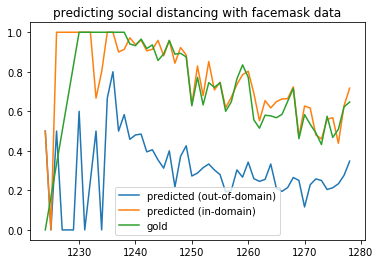

In [171]:
plot_data_predicted_fd = convert(data_predicted_fd)
plot_data_predicted_dd = convert(data_predicted_dd)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.savefig("facemask-to-distancing.png")
plt.show()

### Inflate predictions

In [150]:
def get_freqs(label_list):
    freqs = {}
    for label in label_list:
        if label in freqs:
            freqs[label] += 1
        else:
            freqs[label] = 1
    for label in freqs:
        freqs[label] /= len(label_list)
    return(freqs)

In [151]:
def inflate(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]*factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [172]:
def inflate_plus(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]+factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [173]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__REJECTS': 0.19822020589774908, '__label__SUPPORTS': 0.5632524864770546, '__label__IRRELEVANT': 0.2385273076251963}
0.35192069392812886


In [220]:
FACTOR = 0.9967

predictionLabelsTestFDinflated = list(predictionLabelsTestFD)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestFDinflated, '__label__SUPPORTS', '__label__REJECTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.5379514918862328, '__label__SUPPORTS': 0.34252311987436745, '__label__REJECTS': 0.11952538823939976}
0.34895568008150796


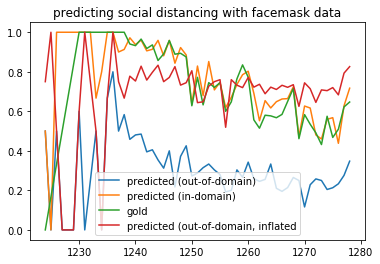

In [221]:
data_predicted_fd_inflated = make_data_predicted(predictionLabelsTestFDinflated, tweet_ids_distance)
plot_data_predicted_fd_inflated = convert(data_predicted_fd_inflated)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
x_fd_inflated = [x[0] for x in plot_data_predicted_fd_inflated]
y_fd_inflated = [x[1] for x in plot_data_predicted_fd_inflated]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_fd_inflated, y_fd_inflated, label="predicted (out-of-domain, inflated")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.savefig("facemask-to-distancing.png")
plt.show()

### Numerical analysis of predictions

In [222]:
plot_data_predicted_fd_dict = { x[0]:x[1] for x in plot_data_predicted_fd }
plot_data_predicted_dd_dict = { x[0]:x[1] for x in plot_data_predicted_dd }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }
plot_data_predicted_fd_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_fd_inflated }

In [223]:
def get_common_key_values(dict1, dict2):
    values1 = []
    values2 = []
    for key in sorted(dict1.keys()):
        if key in dict2:
            values1.append(dict1[key])
            values2.append(dict2[key])
    return(values1, values2)

In [224]:
values_dd, values_gold_dd = get_common_key_values(plot_data_predicted_dd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_dd), np.array(values_dd)).rvalue, 2))
values_fd, values_gold_fd = get_common_key_values(plot_data_predicted_fd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd)).rvalue, 2))
values_fd_inflated, values_gold_fd_inflated = get_common_key_values(plot_data_predicted_fd_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd_inflated)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.88
Pearson r correlation gold vs out-of-domain: 0.47
Pearson r correlation gold vs out-of-domain (inflated): -0.06


In [225]:
def absolute_difference(list1, list2):
    absolute_difference = 0
    for i in range(0, len(list1)):
        absolute_difference += abs(list1[i]-list2[i])
    return(absolute_difference/len(list1))

In [226]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_dd, values_dd), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_fd, values_fd),2))
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_fd_inflated, values_fd_inflated),2)) 

absolute difference gold vs in-domain: 0.06
absolute difference gold vs out-of-domain: 0.42
absolute difference gold vs out-of-domain (inflated): 0.18


## Predicting facemasks with social distancing data

In [17]:
predictionCountsValidationDF,predictionLabelsValidationDF,predictionCountsTestDF,predictionLabelsTestDF = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300)

0 cases: 132; precision: 0.508; recall: 0.508; fraction: 0.245
1 cases: 132; precision: 0.447; recall: 0.447; fraction: 0.219
2 cases: 133; precision: 0.398; recall: 0.398; fraction: 0.135
3 cases: 132; precision: 0.515; recall: 0.515; fraction: 0.110
4 cases: 132; precision: 0.356; recall: 0.356; fraction: 0.238
5 cases: 132; precision: 0.402; recall: 0.402; fraction: 0.145
6 cases: 132; precision: 0.356; recall: 0.356; fraction: 0.284
7 cases: 133; precision: 0.391; recall: 0.391; fraction: 0.227
8 cases: 132; precision: 0.379; recall: 0.379; fraction: 0.207
9 cases: 132; precision: 0.417; recall: 0.417; fraction: 0.385
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  208               144                206
__label__REJECTS                      93               205                251
__label__SUPPORTS                     37                4

In [87]:
predictionCountsValidationDF,predictionLabelsValidationDF,predictionCountsTestDF,predictionLabelsTestDF = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="model-2020.vec")

0 cases: 132; precision: 0.523; recall: 0.523; fraction: 0.259
1 cases: 132; precision: 0.394; recall: 0.394; fraction: 0.148
2 cases: 133; precision: 0.421; recall: 0.421; fraction: 0.143
3 cases: 132; precision: 0.508; recall: 0.508; fraction: 0.109
4 cases: 132; precision: 0.318; recall: 0.318; fraction: 0.234
5 cases: 132; precision: 0.402; recall: 0.402; fraction: 0.143
6 cases: 132; precision: 0.386; recall: 0.386; fraction: 0.247
7 cases: 133; precision: 0.368; recall: 0.368; fraction: 0.205
8 cases: 132; precision: 0.326; recall: 0.326; fraction: 0.163
9 cases: 132; precision: 0.424; recall: 0.424; fraction: 0.262
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  215               135                208
__label__REJECTS                     101               189                259
__label__SUPPORTS                     51                3

In [88]:
store_fasttext_data(predictionLabelsTestDF, "predictionLabelsTestDF.pickle")

In [247]:
predictionLabelsTestDF = read_fasttext_data("predictionLabelsTestDF.pickle")
predictionLabelsTestFF = read_fasttext_data("predictionLabelsTestFF.pickle")

In [248]:
data_predicted_df = make_data_predicted(predictionLabelsTestDF, tweet_ids_facemask, time_factor=1)
data_predicted_ff = make_data_predicted(predictionLabelsTestFF, tweet_ids_facemask, time_factor=1)

In [249]:
gold = []
for tweet in fasttext_data_list_facemask:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_facemask)):
    summary = str(tweet_ids_facemask[i])[0:1]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

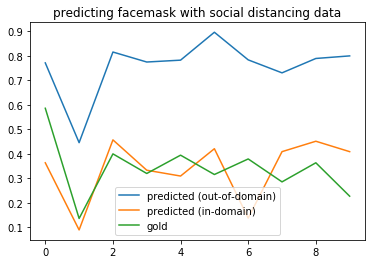

In [250]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-to-facemask.png")
plt.show()

### Inflate predictions

In [251]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.42208774583963693, '__label__REJECTS': 0.4152798789712557, '__label__SUPPORTS': 0.16263237518910742}
2.5534883720930233


In [254]:
FACTOR = 0.9893

predictionLabelsTestDFinflated = list(predictionLabelsTestDF)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestDFinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

{'__label__IRRELEVANT': 0.27760968229954613, '__label__REJECTS': 0.518910741301059, '__label__SUPPORTS': 0.20347957639939485}
2.550185873605948


In [255]:
data_predicted_df_inflated = make_data_predicted(inflate(predictionLabelsTestDFinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR), tweet_ids_facemask, time_factor=1)

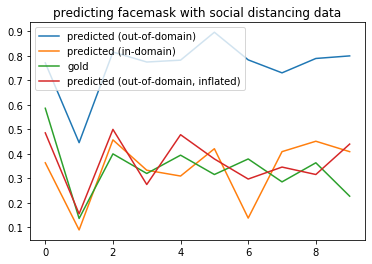

In [256]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_predicted_df_inflated = convert(data_predicted_df_inflated)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
x_df_inflated = [x[0] for x in plot_data_predicted_df_inflated]
y_df_inflated = [x[1] for x in plot_data_predicted_df_inflated]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_df_inflated, y_df_inflated, label="predicted (out-of-domain, inflated)")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-to-facemask.png")
plt.show()

### Numerical analysis of predictions

In [257]:
plot_data_predicted_df_dict = { x[0]:x[1] for x in plot_data_predicted_df }
plot_data_predicted_ff_dict = { x[0]:x[1] for x in plot_data_predicted_ff }
plot_data_predicted_df_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_df_inflated }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [258]:
values_ff, values_gold_ff = get_common_key_values(plot_data_predicted_ff_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_ff), np.array(values_ff)).rvalue, 2))
values_df, values_gold_df = get_common_key_values(plot_data_predicted_df_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_df), np.array(values_df)).rvalue, 2))
values_df_inflated, values_gold_df_inflated = get_common_key_values(plot_data_predicted_df_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_df_inflated), np.array(values_df_inflated)).rvalue, 2))

Pearson r correlation gold vs in-domain: 0.32
Pearson r correlation gold vs out-of-domain: 0.53
Pearson r correlation gold vs out-of-domain (inflated): 0.65


In [259]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_ff, values_ff), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_df, values_df),2)) 
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_df_inflated, values_df_inflated),2)) 

absolute difference gold vs in-domain: 0.12
absolute difference gold vs out-of-domain: 0.42
absolute difference gold vs out-of-domain (inflated): 0.08


### Stop here

In [113]:
print(get_freqs(gold))
print(get_freqs([y[0] for x in predictionLabelsTestFF for y in x[0]]))
print(get_freqs([y[0] for x in predictionLabelsTestDF for y in x[0]]))

{'__label__IRRELEVANT': 0.42208774583963693, '__label__REJECTS': 0.4152798789712557, '__label__SUPPORTS': 0.16263237518910742}
{'__label__IRRELEVANT': 0.38502269288956126, '__label__REJECTS': 0.4750378214826021, '__label__SUPPORTS': 0.13993948562783662}
{'__label__IRRELEVANT': 0.27760968229954613, '__label__REJECTS': 0.26777609682299547, '__label__SUPPORTS': 0.4546142208774584}


In [167]:
predictionCountsValidationF,predictionLabelsValidationF,predictionCountsTestF,predictionLabelsTestF = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300)

0 cases: 132; precision: 0.508; recall: 0.508; fraction: 0.245
1 cases: 132; precision: 0.439; recall: 0.439; fraction: 0.213
2 cases: 133; precision: 0.398; recall: 0.398; fraction: 0.135
3 cases: 132; precision: 0.500; recall: 0.500; fraction: 0.116
4 cases: 132; precision: 0.356; recall: 0.356; fraction: 0.238
5 cases: 132; precision: 0.402; recall: 0.402; fraction: 0.142
6 cases: 132; precision: 0.348; recall: 0.348; fraction: 0.264
7 cases: 133; precision: 0.391; recall: 0.391; fraction: 0.215
8 cases: 132; precision: 0.371; recall: 0.371; fraction: 0.192
9 cases: 132; precision: 0.409; recall: 0.409; fraction: 0.405
 col_0                __label__IRRELEVANT  __label__REJECTS  __label__SUPPORTS
row_0                                                                        
__label__IRRELEVANT                  207               145                206
__label__REJECTS                      96               201                252
__label__SUPPORTS                     38                4

In [151]:
print(get_freqs([y[0] for x in predictionLabelsTestF for y in x[0]]))

{'__label__IRRELEVANT': 0.2586989409984871, '__label__REJECTS': 0.29122541603630864, '__label__SUPPORTS': 0.45007564296520425}
